# 自定义输入Dataset类

In [1]:
import torch
from torch.utils import data
from PIL import Image   #  pip install pillow
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import glob

## 获取图片路径和生成对应标签

In [2]:
# 获取数据集路径
all_imgs_path = glob.glob(r'.\dataset\Weather\*.jpg')
all_imgs_path[:3]

['.\\dataset\\Weather\\cloudy1.jpg',
 '.\\dataset\\Weather\\cloudy10.jpg',
 '.\\dataset\\Weather\\cloudy100.jpg']

In [3]:
# 将标签对应到索引
species = ['cloudy', 'rain', 'shine', 'sunrise']
species_to_idx = dict((c, i) for i, c in enumerate(species))
print("species_to_idx:", species_to_idx)
# 将索引对应到标签
idx_to_species = dict((i, c) for i, c in enumerate(species))
print("idx_to_species:", idx_to_species)

species_to_idx: {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}
idx_to_species: {0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}


In [4]:
# 提取所有图片对应的标签
all_labels = []

for img in all_imgs_path:
    for i, c in enumerate(species):
        if c in img:
            all_labels.append(i)

print("all_labels:", all_labels[-5:])

all_labels: [3, 3, 3, 3, 3]


In [5]:
# 查看图片路径，验证标签是否对应
all_imgs_path[-5:]

['.\\dataset\\Weather\\sunrise95.jpg',
 '.\\dataset\\Weather\\sunrise96.jpg',
 '.\\dataset\\Weather\\sunrise97.jpg',
 '.\\dataset\\Weather\\sunrise98.jpg',
 '.\\dataset\\Weather\\sunrise99.jpg']

## 自定义Dataset类

In [6]:
# 数据集转换
transform = transforms.Compose([
                    transforms.Resize((96, 96)),
                    transforms.ToTensor()
])

In [7]:
# 创建自定义Dataset类，必须创建__init__()、__getitem__()和__len()__三个魔术方法
class Mydataset(data.Dataset):
    def __init__(self, img_paths, labels, transform):   # img_paths和labels 图片路径列表和标签列表
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
        
    def __getitem__(self, index):   # 实现后可以切片数据集，实现图片读取和转换后返回
        img = self.imgs[index]
        label = self.labels[index]
        
        pil_img = Image.open(img)       # 读取图片
        data = self.transforms(pil_img)
        
        return data, label
    
    def __len__(self):              # 实现后可以直接len()获取数据集大小
        return len(self.imgs)

In [8]:
# 初始化自定义数据集
wheather_dataset = Mydataset(all_imgs_path, all_labels, transform)
# 查看自定义数据集类型
print(type(wheather_dataset))

<class '__main__.Mydataset'>


In [9]:
# 创建自定义数据集的DataLoader
BATCH_SIZE = 16
wheather_dl = data.DataLoader(
                      wheather_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
)

## 查看自定义数据集

In [10]:
# 取出一个batch的数据进行查看
imgs_batch, labels_batch = next(iter(wheather_dl))

# 查看batch数据的shape
print("imgs_batch.shape:", imgs_batch.shape)
print("labels_batch.shape:", labels_batch.shape)

imgs_batch.shape: torch.Size([16, 3, 96, 96])
labels_batch.shape: torch.Size([16])


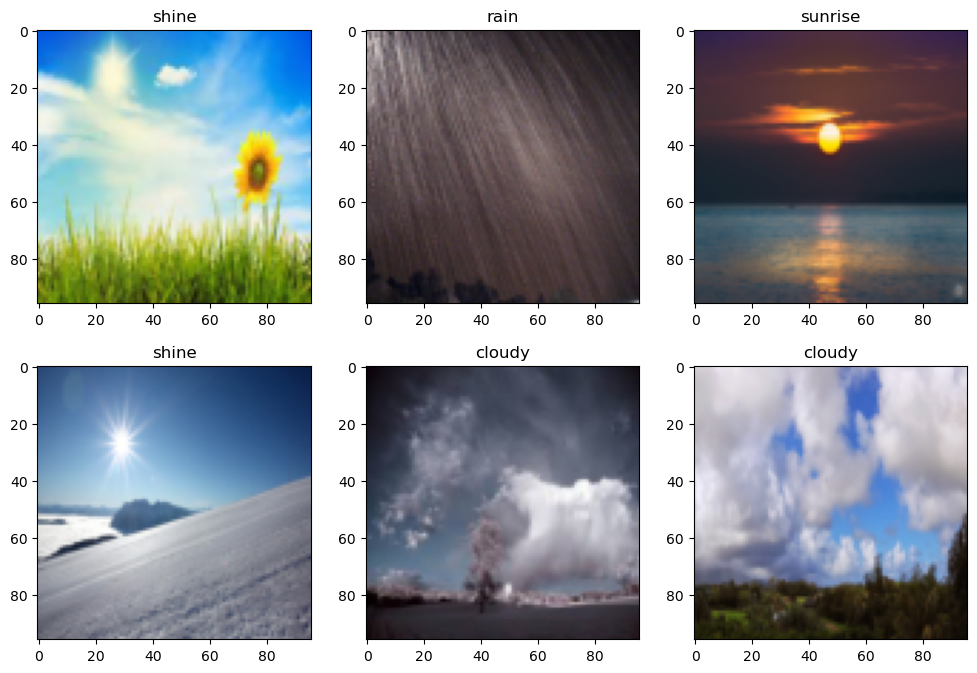

In [11]:
# 查看batch数据图片
plt.figure(figsize=(12, 8))

for i, (img, label) in enumerate(zip(imgs_batch[-6:], labels_batch[-6:])):  # zip()同时对imgs_batch和labels_batch进行迭代，enumerate()添加序号方便绘制子图
    img = img.permute(1, 2, 0).numpy()      # [channel， hight， width] -> [hight， width, channel] 转换为ndarray数据类型
    plt.subplot(2, 3, i+1)                  # 绘制子图，两行三列
    plt.title(idx_to_species.get(label.item()))     # 绘制标签
    plt.imshow(img)

## 划分训练集和测试集

In [12]:
# 将图片和标签进行同样的乱序
index = np.random.permutation(len(all_imgs_path)) # 创建与数据集等长的乱序索引
print(index)
all_imgs_path = np.array(all_imgs_path)[index]    # 对图片使用index进行索引
print(all_imgs_path[:5])
all_labels = np.array(all_labels)[index]          # 对标签使用index进行索引
print(all_labels[:5])

[430 492 123 ... 911 357 569]
['.\\dataset\\Weather\\rain23.jpg' '.\\dataset\\Weather\\rain80.jpg'
 '.\\dataset\\Weather\\cloudy21.jpg' '.\\dataset\\Weather\\cloudy181.jpg'
 '.\\dataset\\Weather\\sunrise45.jpg']
[1 1 0 0 3]


In [13]:
# 划分训练集和测试集
s = int(len(all_imgs_path)*0.8)
print(s)
train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]

897


In [14]:
# 实例化划分后的数据集
train_ds = Mydataset(train_imgs, train_labels, transform)
test_ds = Mydataset(test_imgs, test_labels, transform)

train_dl = data.DataLoader(train_ds,
                           batch_size=16,
                           shuffle=True
)
test_dl = data.DataLoader(test_ds,
                          batch_size=16
)

## 灵活使用Dataset类构建输入数据集

In [15]:
# 查看已经构建的数据集
imgs, labels = next(iter(train_ds))
print("imgs.shape:", imgs.shape)

imgs.shape: torch.Size([3, 96, 96])


In [16]:
# 自定义数据集类
class New_dataset(data.Dataset):
    def __init__(self, some_dataset):
        self.ds = some_dataset
    def __getitem__(self, index):
        img, label = self.ds[index]
        img = img.permute(1, 2, 0)
        return img, label
    def __len__(self):
        return len(self.ds)

In [17]:
# 验证自定义数据集类
train_new_dataset = New_dataset(train_ds)
img, label = train_new_dataset[2]
print("img.shape:", img.shape)

img.shape: torch.Size([96, 96, 3])
